In [1]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from urlparse import urlparse
from nb_utils import (get_ps1_or_ipaddress, read_pcap_fields_from_txts,
                   download_roku_channel_details, ROKU_MACS)

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
HTTP_CSV = join(DATA_DIR, "roku-2019-02-04-requests.csv")
HTTP_CSV2 = join(DATA_DIR, "roku-2018-09-27-requests.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()
channel_df.head()

,_category,_scrape_ts,accessCode,desc,name,payment,price,rankByWatched,rating,thumbnail
id,,,,,,,,,,
12,movies-tvs,1537037970,101D4DEA,Watch TV shows and movies recommended just for...,Netflix,None,0,1,75.890121,http://channels.roku.com/images/f5e60d25f2c944...
2285,movies-tvs,1537037970,hulu,Stream all your TV in one place with Hulu. Get...,Hulu,None,0,3,74.931961,https://image.roku.com/developer_channels/prod...
13,movies-tvs,1537037970,8C42649C,Prime members can watch thousands of movies an...,Prime Video,None,0,4,73.552605,https://image.roku.com/developer_channels/prod...
46041,movies-tvs,1537037970,SlingTV,"Sling TV is Live TV, Only Better. The #1 Live ...",Sling TV,None,0,5,68.119362,https://image.roku.com/developer_channels/prod...
23048,movies-tvs,1537037970,twctv,"With Spectrum TV, you can enjoy up to 250 live...",Spectrum TV,None,0,6,64.740654,https://image.roku.com/developer_channels/prod...


## Load HTTP request details
- Load the request details from the CSV or build from scratch

In [5]:
df = pd.read_csv(HTTP_CSV, sep='\t', encoding='utf-8')

In [6]:
df.head()

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
0,71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/e3d507f1-1ab5-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs
1,71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/ab02c785-7fb5-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs
2,71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/1238048f-acd8-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs
3,71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/67dd5360-fe70-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs
4,71530,1549020784,NaN,NaN,NaN,NaN,GET,http://vhx.imgix.net/tsl/assets/f37df523-a3e1-...,Tribeca Shortlist,imgix.net,vhx.imgix.net,2623,movies-tvs


### HTTP requests - overview

In [7]:
print "%d requests to %d distinct domains %d distinct hosts from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.host.nunique(), df.channel_id.nunique())

42340 requests to 418 distinct domains 730 distinct hosts from 723 distinct channels


### Top domains
- domains contacted by most channels

In [8]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
180,ifood.tv,252
117,doubleclick.net,133
194,irchan.com,106
323,spotxchange.com,101
161,google-analytics.com,66
357,tremorhub.com,59
309,scorecardresearch.com,53
234,monarchads.com,42
388,vimeo.com,40
43,amazonaws.com,38


### Top domains - Kids and family channels

In [9]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"])
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
45,ifood.tv,211
87,spotxchange.com,44
28,doubleclick.net,41
95,tremorhub.com,25
51,irchan.com,20
36,google-analytics.com,18
13,advertising.com,12
4,45.55.53.218,12
102,vidible.tv,12
65,monarchads.com,11


In [10]:
df.category.value_counts

<bound method Series.value_counts of 0         movies-tvs
1         movies-tvs
2         movies-tvs
3         movies-tvs
4         movies-tvs
5         movies-tvs
6         movies-tvs
7         movies-tvs
8         movies-tvs
9        kids-family
10       kids-family
11       kids-family
12       kids-family
13       kids-family
14       kids-family
15       kids-family
16       kids-family
17       kids-family
18       kids-family
19       kids-family
20       kids-family
21       kids-family
22       kids-family
23       kids-family
24       kids-family
25       kids-family
26       kids-family
27       kids-family
28       kids-family
29       kids-family
            ...     
42310     movies-tvs
42311     movies-tvs
42312     movies-tvs
42313     movies-tvs
42314     movies-tvs
42315     movies-tvs
42316     movies-tvs
42317     movies-tvs
42318     movies-tvs
42319     movies-tvs
42320     movies-tvs
42321     movies-tvs
42322     movies-tvs
42323     movies-tvs
42324     movies-t

### Channels contacting the most domains

In [11]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
6,8ctave HD,936,59
690,WatchFreeHorrorFlix,716,42
520,Retromedia TV,741,23
423,Manic Movies,2459,19
432,Miss Misery's Movie Massacre,1118,17
631,Timeless TV Westerns,1161,17
329,INC,977,16
387,Kings Movie House,734,15
533,Sci-fi Classic TV Shows,2049,14
529,Sally Jessy Raphael by Nosey,1491,14


### Kids and family channels contacting the most domains

In [12]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains
275,The Baby Channel,3739,11
222,Nick Jr.,29,9
223,Nickelodeon,56,9
224,North Pole Network,3504,8
311,VIDA TV,5507,7
18,Baby Box,1653,6
137,Haunted House Español,5229,5
90,Enchanted Tales,2646,5
159,Kiddovid,3168,5
36,Booya,4676,5


### Effect of popularity (rank)
- Do popular channels contact more domains?

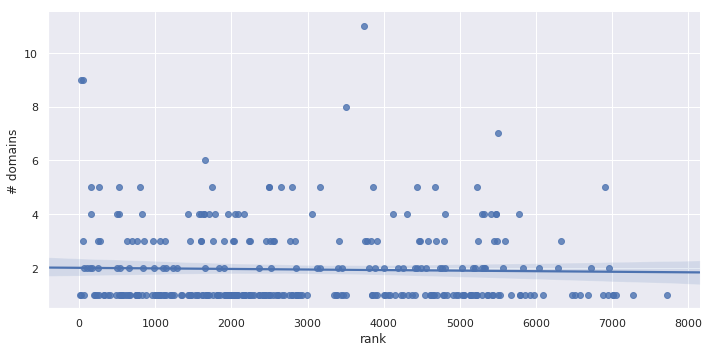

In [13]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, height=5, aspect=2)

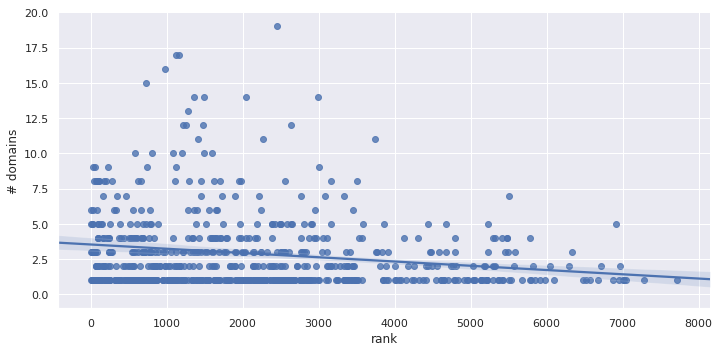

In [14]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, height=5, aspect=2)
ax.set(ylim=(-1, 20))

### TODOs
- what are the domains that are TV/OTT only (e.g. checking on the HTTPArchive data`spotxchange.com` domain is never seen on the web)
- we don't include channels with zero HTTP requests into this analysis (i.e. the above plots need to be redrawn)

In [15]:
df.sort_values("rank", inplace=True)
df[df.url.str.contains("doubleclick")]

,channel_id,start_ts,command,select_idx,eth_src,ip_dst,req_method,url,channel_name,domain,host,rank,category
42243,38896,1548210593,NaN,NaN,NaN,NaN,GET,http://gcdn.2mdn.net/videoplayback/id/bbf1da49...,WatchFreeFlix,2mdn.net,gcdn.2mdn.net,81,movies-tvs
42254,38896,1548210593,NaN,NaN,NaN,NaN,GET,http://r4---sn-ab5szn76.c.2mdn.net/videoplayba...,WatchFreeFlix,2mdn.net,r4---sn-ab5szn76.c.2mdn.net,81,movies-tvs
42251,38896,1548210593,NaN,NaN,NaN,NaN,GET,http://gcdn.2mdn.net/videoplayback/id/bbf1da49...,WatchFreeFlix,2mdn.net,gcdn.2mdn.net,81,movies-tvs
42250,38896,1548210593,NaN,NaN,NaN,NaN,GET,http://r4---sn-ab5szn76.c.2mdn.net/videoplayba...,WatchFreeFlix,2mdn.net,r4---sn-ab5szn76.c.2mdn.net,81,movies-tvs
9029,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/gampad/ads?iu=...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
9031,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
9032,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
9033,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/pagead/convers...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
9030,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/gampad/ads?iu=...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
9025,6119,1548213922,NaN,NaN,NaN,NaN,GET,http://pubads.g.doubleclick.net/gampad/ads?iu=...,Popcornflix,doubleclick.net,pubads.g.doubleclick.net,94,movies-tvs
